#### Fluorescence Plaques

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray

import PyPlaque
from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.phenotypes import Plaque, FluorescencePlaque
from PyPlaque.specimen import (PlaquesImageGray, PlaquesImageRGB, PlaquesMask, PlaquesWell, 
                                PlateImage)
from PyPlaque.utils import centroid, check_numbers, fixed_threshold, stitch_wells, get_plaque_mask, \
      getAllPlaqueRegions, remove_background, remove_artifacts, PlaqueImageReadout

In [2]:
#loading multiple plates and plate masks as an experiment
exp = ExperimentFluorescencePlaque('../data/samples_fluorescent_plaques/images',
                                   '../data/samples_fluorescent_plaques/masks/')

In [3]:
#In this case the individual plates are of 384 well plates for fluorescence plaques and 
#their corresponding mask directories
plate_dirs, plate_mask_dirs = exp.get_individual_plates()

In [4]:

print(plate_dirs, plate_mask_dirs)

['200601-zplate-g2', '200528-zplate-g1'] ['200601-zplate-g2', '200528-zplate-g1']


In [5]:
exp.get_number_of_plates() 
#This number is accurate but we are choosing to ignore other plates other than just one

2

In [6]:
channel_1_identifier = 'w1'
channel_2_identifier = 'w2'

In [10]:
#testing functionality to stitch some of the wells together to form the whole image
plate_dict_w1 = {}

d = plate_dirs[0]

i = 1
plate_dict_w1[d] = {}
plate_dict_w1[d]['img'] = {}
plate_dict_w1[d]['mask'] = {}
for f in os.listdir(os.path.join(exp.plate_folder,d,'2020-06-03','2072')):
    try:
        if channel_1_identifier in f:
            plate_dict_w1[d]['img'][i] = np.asarray(exp.read_from_path(
            str(os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)),color_mode="grayscale"))
            i+=1
    except:
        continue
    # plate_dict_w1[d]['mask'][i] = exp.read_from_path(str(os.path.join(exp.plate_mask_folder,d,f)))
    # plt.figure()
    # plt.title(d)
    # plt.axis('off')
    # plt.imshow(plate_dict_w1[d]['mask'][i])
        
    

In [11]:
plate_dict_w1[plate_dirs[0]]['img'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [12]:
img_list = list(plate_dict_w1[plate_dirs[0]]['img'].values())
len(img_list)

384

In [13]:
#Trying the functionality to stitch individual wells into a composite image
#The images should be in raster scan fashion from left to right, row by row
composite_img = stitch_wells(img_list,nrows = 16,ncols = 24)
print(composite_img.shape)



(32768, 49152)


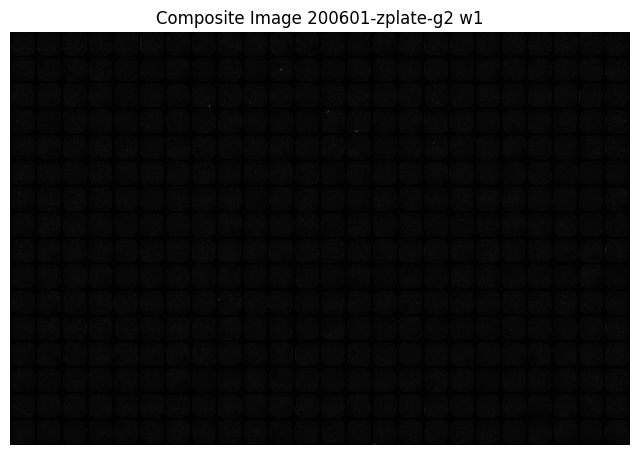

In [14]:
plt.figure(figsize=(8,12))
plt.title("Composite Image " + plate_dirs[0] + " w1")
plt.axis('off')

plt.imshow(composite_img, cmap='gray')

#Unfortunately the image is more clearly visible only in fiji after converting to 8/16bit and some 
# thresholding
# plt.savefig("../../../manuscript/figs/" + plate_dirs[0] + "_w1 Stitched images.png", 
# bbox_inches = 'tight', dpi=300)

In [15]:
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        "nearest": pil_image.NEAREST,
        "bilinear": pil_image.BILINEAR,
        "bicubic": pil_image.BICUBIC,
        "hamming": pil_image.HAMMING,
        "box": pil_image.BOX,
        "lanczos": pil_image.LANCZOS,
    }

In [16]:
ar = np.array(composite_img, dtype=np.uint16)
im = pil_image.fromarray(ar)
# im.save("../../../manuscript/figs/" + plate_dirs[0] + "_w1 Stitched images2.png")
# is 7 times slower than previous method and results in a huge file size muc bigger than
# original but yields a b/w image that can be thresholded in Fiji

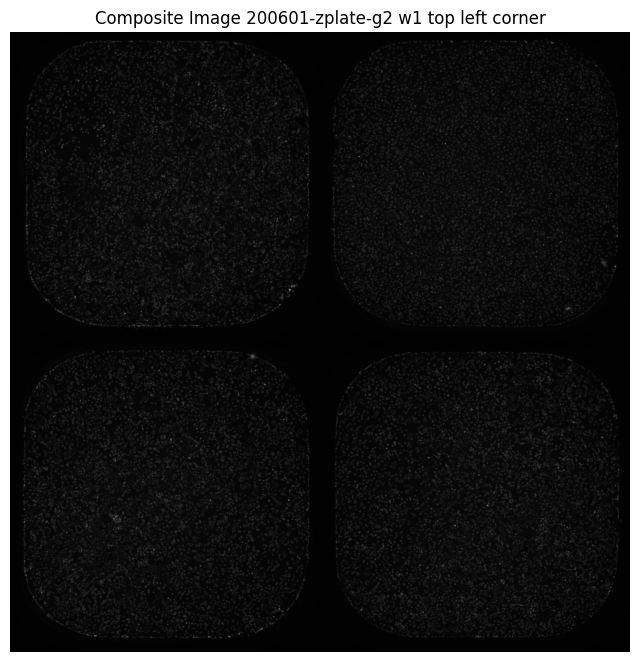

In [17]:
# we can also combine a portion of the images instead of all 
composite_img_corner = stitch_wells([img_list[i] for i in (0,1,16,17)],nrows = 2,ncols = 2) 
#this indicates the top left corner of the 384 well plate

plt.figure(figsize=(8,12))
plt.title("Composite Image " + plate_dirs[0] + " w1 top left corner")
plt.axis('off')

plt.imshow(composite_img_corner, cmap='gray')
# plt.imsave(f"../../../manuscript/figs/" + plate_dirs[0] + "_w1 stitched top left corner.png", 
# composite_img_corner, cmap='gray')
# plt.savefig("../../../manuscript/figs/" + plate_dirs[0] + "_w1 stitched top left corner.png", 
# bbox_inches = 'tight', dpi=300)

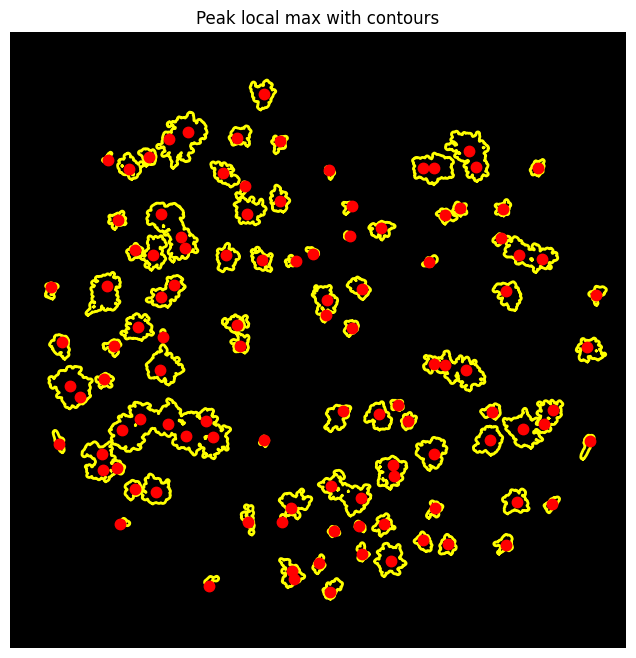

In [18]:
#picking out the plaques mask from the image using peak local maxima
import tifffile as TIFF
from matplotlib import cm
from skimage import measure

# Read a grayscale image (replace 'path/to/your/image.png' with the actual path to your image file)
inputImage = TIFF.imread('../data/samples_fluorescent_plaques/images/B01_w2.TIF')

# Define the virus parameters dictionary
virus_params = {
    'min_plaque_area': 2000,
    'virus_threshold': 10,
    'plaque_connectivity': 10,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 30,
    'plaque_gaussian_filter_sigma': 10,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}

finalPlqRegImage, globalPeakCoords = get_plaque_mask(inputImage,virus_params)
fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(inputImage, cmap=plt.cm.gray, vmin=500, vmax=6000, alpha=1, extent=[0, inputImage.shape[1], 
                                                                              inputImage.shape[0], 0])
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)

# Find contours in finalPlqRegImage
contours = measure.find_contours(finalPlqRegImage)

# Plot contours with random colors
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='yellow')

ax.plot(globalPeakCoords[:, 1], globalPeakCoords[:, 0], 'r.', markersize=15)
ax.axis('off')
ax.set_title('Peak local max with contours')

plt.show()

In [19]:
##Number of plaques in the image
print(len(globalPeakCoords))

110


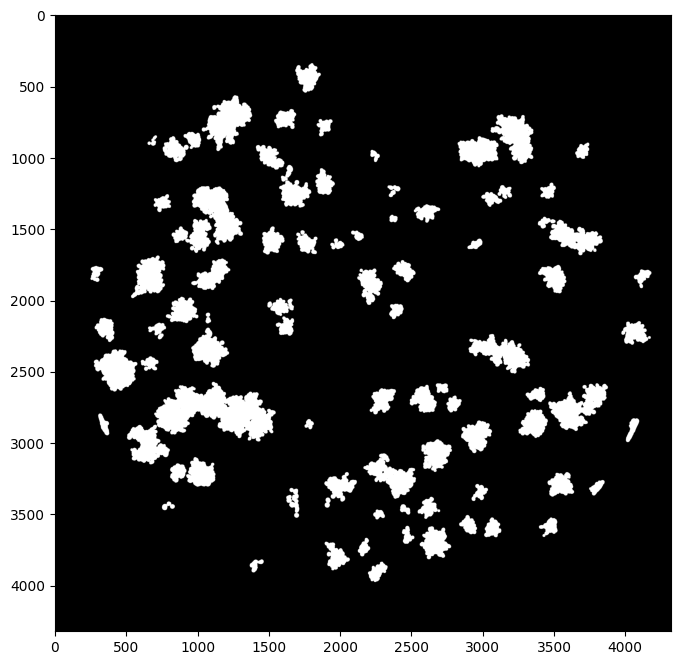

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(finalPlqRegImage,cmap='gray')
plt.show()

In [21]:
# Reading back all the individual wells as tif files instead of using the default
# read_from_path module

image_bits = 16
virus_params = {
    'min_plaque_area': 2000,
    #'virus_threshold': 0.006 * (2**image_bits - 1),
    'virus_threshold': 0.03 * (2**image_bits - 1),
    'plaque_connectivity': 4,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 90,
    'plaque_gaussian_filter_sigma': 30,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}

plate_dict_w2 = {}

d = plate_dirs[0]

i = 1
plate_dict_w2[d] = {}
plate_dict_w2[d]['img'] = {}
plate_dict_w2[d]['mask'] = {}
plate_dict_w2[d]['image_name'] = {}
for f in os.listdir(os.path.join(exp.plate_folder,d,'2020-06-03','2072')):
    if i >= 6 :
        break
    try:
        if channel_2_identifier in f:
            plate_dict_w2[d]['img'][i] = TIFF.imread(
            str(os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)))
            plate_dict_w2[d]['image_name'][i] = f
            bg, bg_removed_img = remove_background(plate_dict_w2[d]['img'][i],
                                radius=virus_params['correctionBallRadius'])
            plate_dict_w2[d]['mask'][i] = get_plaque_mask(bg_removed_img,virus_params)[0]
            i+=1
    except:
        continue


In [22]:
img_list_w2 = list(plate_dict_w2[plate_dirs[0]]['img'].values())
len(img_list_w2)

5

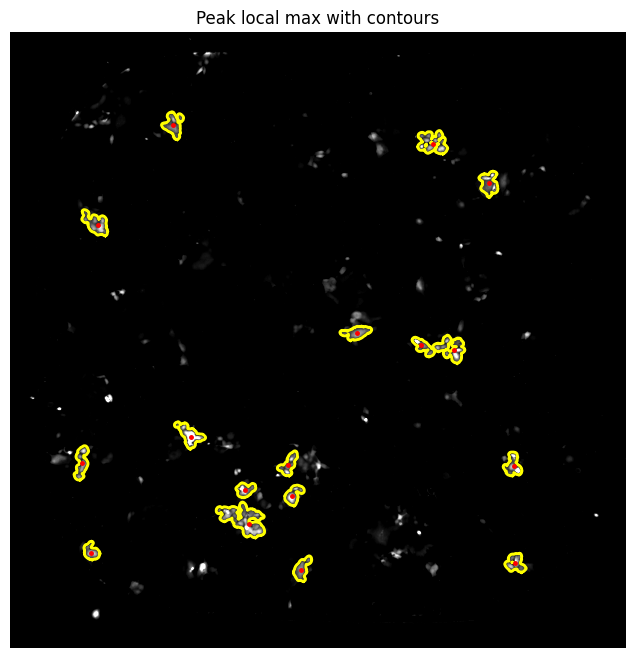

In [24]:
#Analysis of individual wells of 384 well plates seen before, channel 2

# Define the virus parameters dictionary
image_bits = 16
virus_params = {
    'min_plaque_area': 2000,
    # 'virus_threshold': 0.006 * (2**image_bits - 1),
    'virus_threshold': 0.03 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 90,
    'plaque_gaussian_filter_sigma': 30,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}

bg, bg_removed_img = remove_background(img_list_w2[0],
                                  radius=virus_params['correctionBallRadius'])
finalPlqRegImage, globalPeakCoords = get_plaque_mask(bg_removed_img,virus_params)
fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(bg_removed_img, cmap=plt.cm.gray, vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            img_list_w2[0].shape[1], img_list_w2[0].shape[0], 0])
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)

# Find contours in finalPlqRegImage
contours = measure.find_contours(finalPlqRegImage)

# Plot contours with random colors
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='yellow')

ax.plot(globalPeakCoords[:, 1], globalPeakCoords[:, 0], 'r.', markersize=5)
ax.axis('off')

ax.set_title('Peak local max with contours')
# plt.savefig("../../../manuscript/figs/fp_plaque_mask_outline.png", bbox_inches='tight')
plt.show()

In [25]:
print(len(globalPeakCoords))

17


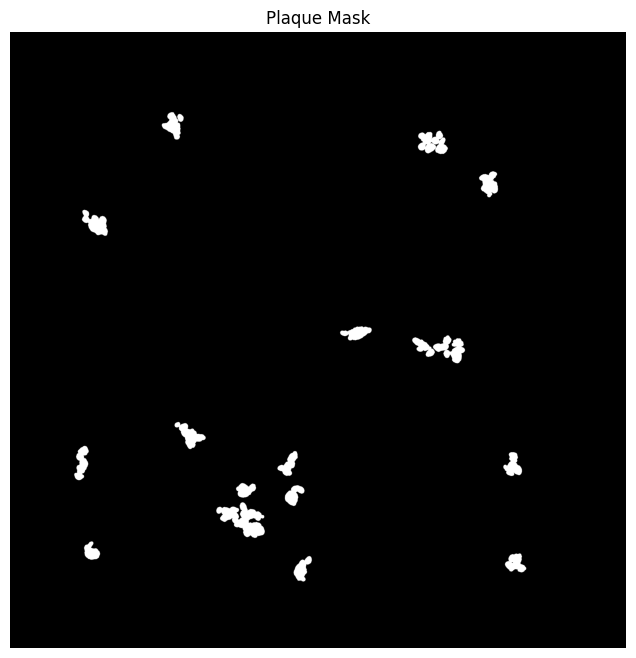

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(finalPlqRegImage,cmap='gray')
ax.axis('off')

ax.set_title('Plaque Mask')
# plt.savefig("../../../manuscript/figs/fp_plaque_mask.png", bbox_inches='tight')
plt.show()

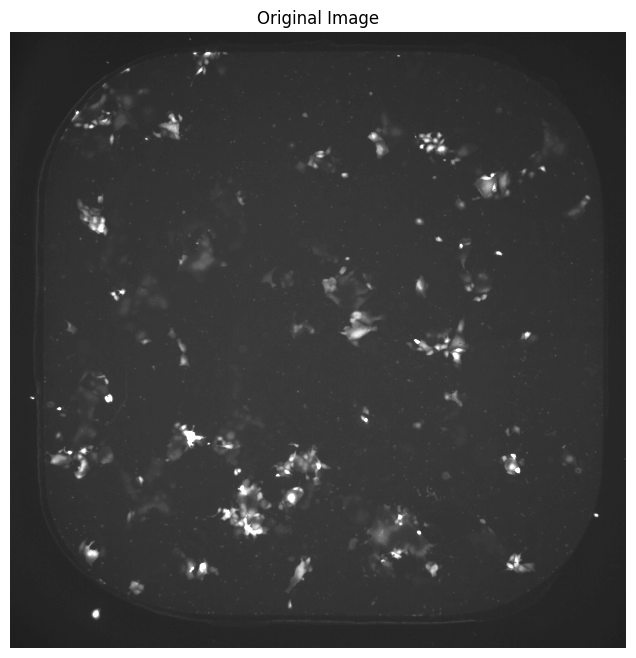

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(img_list_w2[0], cmap=plt.cm.gray, vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            img_list_w2[0].shape[1], img_list_w2[0].shape[0], 0])
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)
ax.axis('off')

ax.set_title('Original Image')
# plt.savefig("../../../manuscript/figs/fp_original_image.png", bbox_inches='tight')
plt.show()

In [28]:
# Reading back all the individual wells as tif files instead of using the default
# read_from_path module

image_bits = 16
nuclei_params = {
    'min_plaque_area': 2000,
    # 'virus_threshold': 0.008 * (2**image_bits - 1),
    'virus_threshold': 0.03 * (2**image_bits - 1),
    'artifact_threshold': 0.5 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 90,
    'plaque_gaussian_filter_sigma': 30,
    'peak_region_size': 10,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}

plate_dict_w1 = {}

d = plate_dirs[0]

i = 1
plate_dict_w1[d] = {}
plate_dict_w1[d]['img'] = {}
plate_dict_w1[d]['mask'] = {}
plate_dict_w1[d]['image_name'] = {}
for f in os.listdir(os.path.join(exp.plate_folder,d,'2020-06-03','2072')):
    if i >= 6 :
        break
    try:
        if channel_1_identifier in f:
            plate_dict_w1[d]['img'][i] = TIFF.imread(
            str(os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)))
            plate_dict_w1[d]['image_name'][i] = f
            artifact_removed_img = remove_artifacts(plate_dict_w1[d]['img'][i],
                                        artifact_threshold=nuclei_params['artifact_threshold'])
            bg, bg_removed_img = remove_background(artifact_removed_img,
                                radius=nuclei_params['correctionBallRadius'])
            plate_dict_w1[d]['mask'][i] = get_plaque_mask(bg_removed_img,nuclei_params)[0]
            i+=1
    except:
        continue
        
    

In [29]:
img_list_w1 = list(plate_dict_w1[plate_dirs[0]]['img'].values())
len(img_list_w1)

5

Text(0.5, 1.0, 'Peak local max with contours')

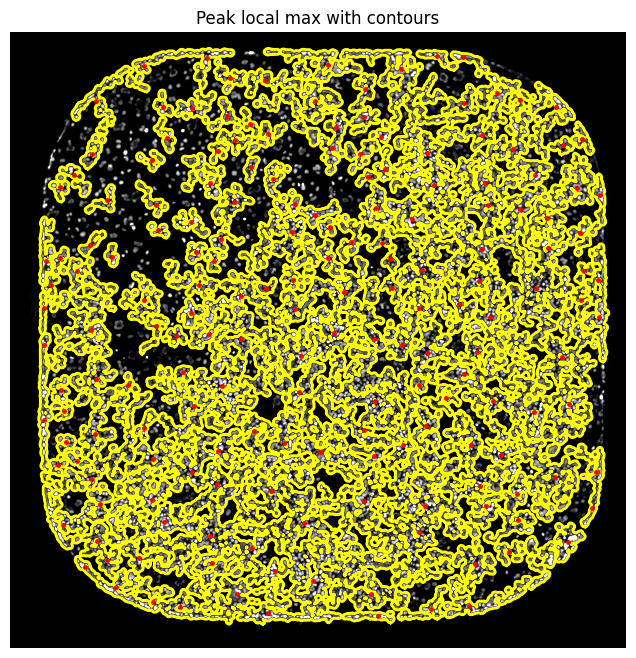

In [30]:
#Analysis of individual wells of 384 well plates seen before, channel 1

# Define the virus parameters dictionary
image_bits = 16
nuclei_params = {
    'min_plaque_area': 2000,
    # 'virus_threshold': 0.008 * (2**image_bits - 1),
    'virus_threshold': 0.03 * (2**image_bits - 1),
    'artifact_threshold': 0.5 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 90,
    'plaque_gaussian_filter_sigma': 30,
    'peak_region_size': 10,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}
#Use only thresholding and divide by average size of nuclei
inputImage = img_list_w1[0]

artifact_removed_img = remove_artifacts(img_list_w1[0],
                                        artifact_threshold=nuclei_params['artifact_threshold'])
bg, bg_removed_img = remove_background(artifact_removed_img,
                                        radius=nuclei_params['correctionBallRadius'])
finalPlqRegImage, globalPeakCoords = get_plaque_mask(bg_removed_img,nuclei_params)
fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(bg_removed_img, cmap=plt.cm.gray, vmin=500, vmax=6000, alpha=1, extent=[0, 
                                                    inputImage.shape[1], inputImage.shape[0], 0])
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)

# Find contours in finalPlqRegImage
contours = measure.find_contours(finalPlqRegImage)

# Plot contours with random colors
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='yellow')

ax.plot(globalPeakCoords[:, 1], globalPeakCoords[:, 0], 'r.', markersize=5)
ax.axis('off')
ax.set_title('Peak local max with contours')
# plt.savefig("../../../manuscript/figs/fp_plaque_mask_outline_w1.png", bbox_inches='tight')

In [31]:
print(len(globalPeakCoords))

182


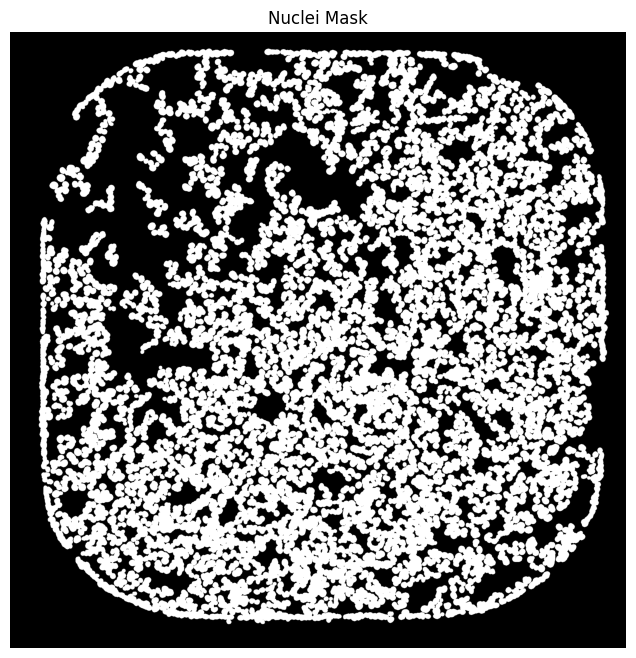

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(finalPlqRegImage,cmap='gray')
ax.axis('off')

ax.set_title('Nuclei Mask')
# plt.savefig("../../../manuscript/figs/fp_nuclei_mask_w1.png", bbox_inches='tight')
plt.show()

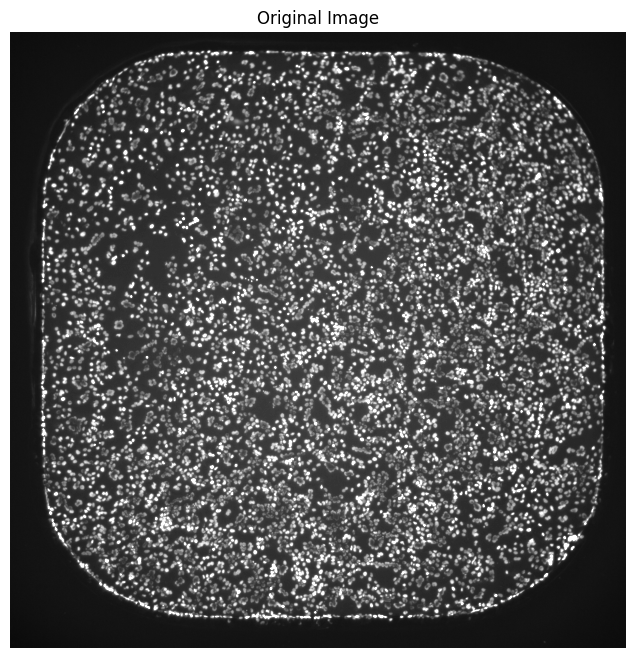

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(img_list_w1[0], cmap=plt.cm.gray, vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            img_list_w1[0].shape[1], img_list_w1[0].shape[0], 0])
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)
ax.axis('off')

ax.set_title('Original Image')
# plt.savefig("../../../manuscript/figs/fp_original_image_w1.png", bbox_inches='tight')
plt.show()

In [34]:
#Generating readouts for images as in PyPlaque in Matlab
#Assuming that w1 is the nuclei channel and w2 as the plaque channel


plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                       ['image_name'][1],
                         plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][1],
                         nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][1]),
                         plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][1]),
                         nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][1]),
                         plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][1]),
                         virus_params = virus_params)

In [35]:
print(plq_image_readout.get_nuclei_image_name())
print(plq_image_readout.get_row())
print(int(plq_image_readout.get_column()))
print(plq_image_readout.get_max_nuclei_intensity())
print(plq_image_readout.get_total_nuclei_intensity())
print(plq_image_readout.get_mean_nuclei_intensity())
print(plq_image_readout.get_nuclei_count())

200601-zplate-g2_O04_s1_w1.tif
O
4
32710
5476984633
1083.7425883787698
21570


In [36]:
print(plq_image_readout.get_plaque_image_name())
print(plq_image_readout.get_row())
print(int(plq_image_readout.get_column()))
print(plq_image_readout.get_max_plaque_intensity())
print(plq_image_readout.get_total_plaque_intensity())
print(plq_image_readout.get_mean_plaque_intensity())
print(plq_image_readout.get_median_plaque_intensity())
print(plq_image_readout.get_plaque_count())
print(plq_image_readout.get_infected_nuclei_count())
print(plq_image_readout.get_lesion_area())

200601-zplate-g2_O09_s1_w2.tif
O
4
13546
157121187
1086.7575371270864
1051.0
13
448
38045


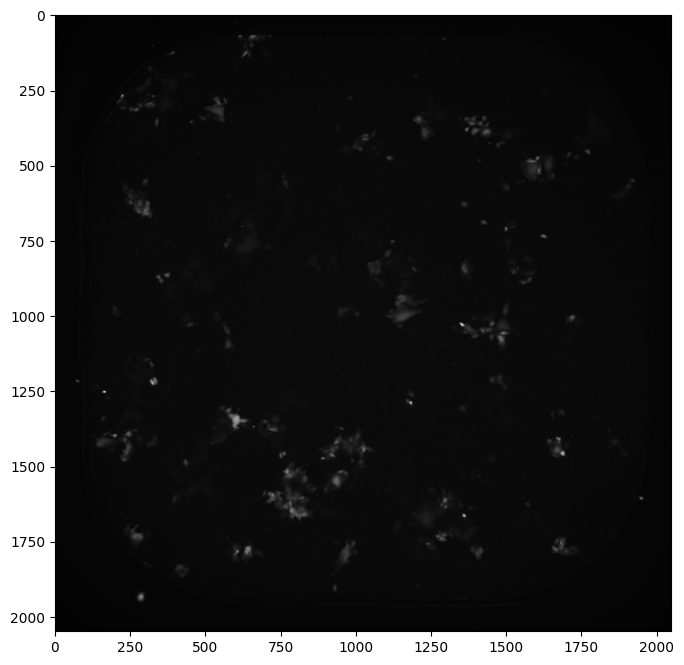

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(plq_image_readout.plaque_image,cmap='gray')
plt.show()

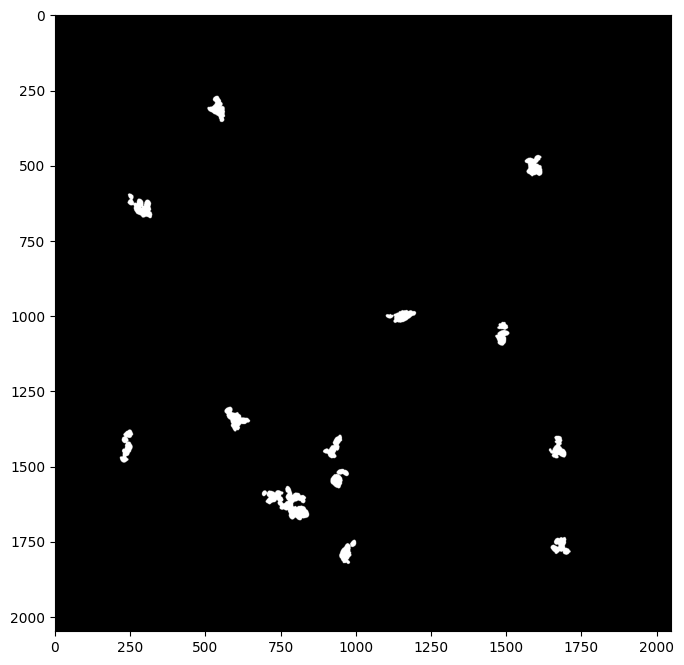

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(plq_image_readout.plaque_mask,cmap='gray')
plt.show()

In [39]:
#Generating readouts for objects as in PyPlaque in Matlab
#Assuming that w1 is the nuclei channel and w2 as the plaque channel

plq_objects = plq_image_readout.get_plaque_objects()
len(plq_objects)

13

In [40]:
plq_object_readout = plq_image_readout.call_plaque_object_readout(plq_objects[1],virus_params)

In [41]:
print(plq_object_readout.get_row())
print(plq_object_readout.get_column())
print(plq_object_readout.get_area())
print(plq_object_readout.get_centroid())
print(plq_object_readout.get_bbox())
print(plq_object_readout.get_major_minor_axis_length())
print(plq_object_readout.get_eccentricity())
print(plq_object_readout.get_convex_area())
print(plq_object_readout.roundness())
print(len(plq_object_readout.get_number_of_peaks()))
print(plq_object_readout.get_nuclei_in_plaque())
print(plq_object_readout.get_infected_nuclei_in_plaque())
print(plq_object_readout.get_max_intensity_GFP())
print(plq_object_readout.get_total_intensity_GFP())
print(plq_object_readout.get_mean_intensity_GFP())

O
04
2760
(502.18659420289856, 1592.8101449275362)
(465, 1621, 72, 60)
(73.82344695759377, 55.222839326016924)
0.6636544363741379
3468.0
0.5999383944138149
1
33.68235294117647
26.764705882352942
9312
10627987
34.49836956521739


### Rough Work


In [31]:
len(img_list)

384

In [32]:
img_list[(192+24)].shape

(2048, 2048)

In [33]:
for img in img_list:
    if img.shape[0]!=2048 and img.shape[1]!=2048:
        print(img)

In [34]:
ncols = 24
nrows = 16
img_array = img_list

combined_img = np.array([])
for k in range(nrows):
    temp = np.concatenate([np.squeeze(img_array[i]) for i in range(ncols)],axis=1).astype(np.float32)
    img_array = img_array[ncols:]
    combined_img = np.vstack([combined_img,temp]).astype(np.float32) if combined_img.size else temp
    
    